# Calculating mean and standard deviation

**np.mean(data)** will return the mean of all the values in data

**np.std(data)** will return the population standard deviation for all the values in data

**np.std(data,ddof=1)** will return the sample standard deviation for all the values in data. This is the one you should use when data represents only a subset of all the possible values that exist. When you make measurements you are always only get a sample. 

**Make an array of random values** to simultate T(t) and print them out to make sure they look right. np.random.randn() returns a normally distributed random number with a mean of zero and a standard deviation of 1, but we'll ignore that for the moment.

The examples below explore the differences and some ways we can calculate the values as we go along in a microcontroller application.

First import a bunch of components we will use


In [1]:
# gets all of numpy but you will still need to refer to e.g. numpy.random.randn() as random.randn()
from numpy import *               # all of the array capable elements for numerical data          
from scipy.stats import norm      # comprehensive functions for Gaussian normal distributions
import csv                        # library for reading and writing comma separated value files
from matplotlib.pyplot import *   # all of pyplot to graph the results of our calculations

# put figures inline in the notebook, so you don't have to call show()
%matplotlib inline

# This lets you make the default figure size larger (or smaller)
from IPython.core.pylabtools import figsize
figsize(14, 7)

Create a bunch of discrete times when we would sample the temperature, then create a matching set of temperature values. By specifying the population mean and standard deviation to sample from, we know roughly what our sample results should be.

In [2]:
cnt =111
t = linspace(0,1,cnt)
Tbar = 24
sigmaT = 0.3
T = Tbar + sigmaT * np.random.randn(cnt)

Plot T(t) to make sure it looks like the data we saw from the actual temperature transducer.

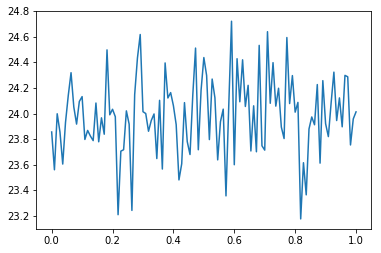

In [3]:
plot(t,T)

mean() and std() are numpy functions to calculate the mean and standard deviation and they behave a little differently than the matlab versions. Try http://stackoverflow.com/questions/27600207/why-does-numpy-std-give-a-different-result-to-matlab-std for some details.

std() will return the population standard deviation by default. To get the sample standard deviation (what we usually want because we don't have all the possible temperature measurements, just the ones we sampled) you need to specify ddof = 1 to get the library to use N-1 instead of N. They'll be very close unless N is small.

In [4]:
print(mean(T),std(T),std(T,ddof=1))

23.985646634667365 0.30331008541692805 0.30468564841689016


## Calculating mean and SD directly 
Check and make sure that we get the same results by direct calculation. With a little manipulation we don't need to calculate the mean and the differences all the way through, just the sum and the sum of the squares. The mean is simply

\begin{equation}
\bar{T} = \frac{\Sigma T}{N}
\end{equation}

which can be calculated by keeping a running sum of all the temperature values and the number of samples. The variance is the square of the standard deviation and at first it looks like you need to know the mean before you can start the calculation:

\begin{equation}
s^2_T = \frac{\Sigma (T-\bar{T})^2}{N-1}\quad
= \quad \frac{\Sigma (T^2-2T\bar{T}+\bar{T}^2)}{N-1}\quad
= \quad \frac{\Sigma T^2 - 2\Sigma T\Sigma T/N + (\Sigma{T})^2/N}{N-1}
\end{equation}

It turns out the variance simplifies so that you only need a running total of temperature, temperature squared and the number of points.
\begin{equation}
s^2_T = \frac{\Sigma T^2 - (\Sigma{T})^2/N}{N-1}
\end{equation}

This makes it easier to keep on updating your calculations each time you get a new data point. Then you can calculate the standard deviation as the square root of the variance. 

This is **easy to implement on a microcontroller** without keeping every data point. It saves storage space and calculation time so the controller can respond to changes in real time.



In [5]:
sumd2 = sum2 = sm = 0
for i in range(0,cnt):
    sm = sm + T[i]
    sum2 = sum2 + T[i]**2
Tb = sm/cnt

Now calculate the standard deviation both ways as a test

In [6]:
for i in range(0,cnt):
    sumd2 = sumd2 + (T[i] - Tb)**2
sT = (sumd2/(cnt-1))**0.5
sT_run = ((sum2 - sm**2/cnt)/(cnt-1)) ** 0.5
print(Tb,sT,sT_run)

23.985646634667365 0.30468564841689016 0.30468564841741824


Get a single new temperature value and use it to calculate a new mean temperature, then check that it works.

In [7]:
Tnew = Tbar + sigmaT * np.random.randn(1)
Tn = Tnew[0]
T = np.append(T,Tn)
cnt = cnt + 1
Tn

24.011314725348832

\begin{equation}
\bar{T}_{\rm new} = \frac{1}{N}\Sigma_{i=1}^N T 
= \frac{T_N + \Sigma_{i=1}^{N-1} T}{N}
= \frac{T_N}{N} + \frac{(N-1)\bar{T}_{\rm old}}{N}
\end{equation}

In [8]:
Tb = (cnt-1)/(cnt) * Tb + 1/cnt * Tn
print(Tb,np.mean(T))

24.024652609268067 24.02465260926809


Notice that 

\begin{equation}
\bar{T}_{\rm new} = w \bar{T}_{\rm old} + (1-w) T_{\rm new}
\end{equation}

where the weight $w = (N-1)/N$ is almost 1. Almost all the weight is put on the old mean value and only a little weight on the latest temperature reading. 

What would happen if we just set $w$ to a constant?

Initially $w$ would be too big and we would put too much weight on the old values, but soon $w$ would be too small and we would be putting extra weight on the newest values and less weight on the oldest. This would give us a moving average with the strongest weight on the most recent data recorded. We will explore this idea later when we look at exponential smoothing.